<a href="https://colab.research.google.com/github/casiopeaw/TDTest2/blob/main/cnn_dataaug_catsdogs_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Conectemonos a Google Drive y preparemos los datos

Los datos los podeis encontrar en esta URL de Google Drive
https://drive.google.com/open?id=1cCjzuanxmL15vz0xVt1BsFL1tBZZD0ox

Movedlos a vuestro Drive!!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

## 3. Definimos algunas constantes

In [3]:
ANCHO_IMAGEN=150
ALTURA_IMAGEN=150
IMAGE_SIZE=(ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES=3

ruta = "/content/drive/MyDrive/perrosgatos/"

## 4. Preparamos los datos de entrenamiento

Los cargaremos del formato NPZ que comentamos en la última clase, y que tenemos en el Drive



In [4]:
dict_npz = np.load(ruta+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [5]:
print("Tamaño X train:", x_train_scaled.shape)
print("Tamaño Y train:", y_train_img.shape)

print("Tamaño X test:", x_test_scaled.shape)
print("Tamaño Y test:", y_test_img.shape)

print("Tamaño X val:", x_val_scaled.shape)
print("Tamaño Y val:", y_val_img.shape)



Tamaño X train: (2916, 150, 150, 3)
Tamaño Y train: (2916,)
Tamaño X test: (989, 150, 150, 3)
Tamaño Y test: (989,)
Tamaño X val: (988, 150, 150, 3)
Tamaño Y val: (988,)


## 5. Exploremos los datos

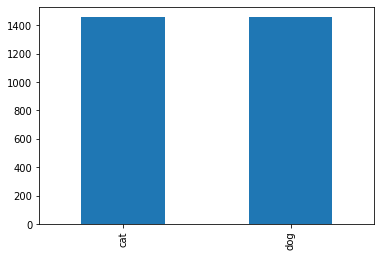

In [6]:
df_train = pd.DataFrame(y_train_img, columns=['category'])
df_train['category'].value_counts().plot.bar()

Como podemos ver tenemos 1458 ejemplos de cada clase... poquito para ser una red neuronal para vision por computador... ya vereis...

## 6. Pintemos una imagen

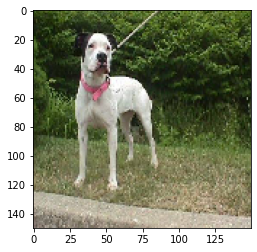

In [7]:
sample = random.choice(range(0,1457))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)

## 7. Apilemos bloques para hacer el modelo

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

In [8]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1, activation='sigmoid')) # 1 de salida porque tenemos dos valores posibles 0 o 1 (tras aplicar un label encoder a dog y cat)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## 8. Montemos el optimizador compilando el modelo


In [9]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

## 9. Definamos un callback para el Early Stopping

**Early Stopping**

Prevenimos el sobre ajuste parando cuando tras 10 epochs y el error de la validacion no decrementa (estamos en una plateau)

In [10]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 10. Preparamos los datos

Haremos un one-hote encoding que nos va a ir bien para nuestra clasificación

In [11]:
y_train_img

array(['dog', 'cat', 'dog', ..., 'dog', 'dog', 'cat'], dtype='<U3')

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [13]:
y_train_encoded

array([1, 0, 1, ..., 1, 1, 0])

## 11. Transformador de imagenes a datos consumibles por la red neuronal

**De entrenamiento**

Aquí incluiremos nuestra parte de generación de imagenes (con código de partida)

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    )

train_generator = train_datagen.flow(
    x_train_img, 
    y_train_encoded, 
    batch_size=30
)

**De validacion y de testeo**

Fijaos que aquí la única modificación es un re-escalado, nada de modificaciones

In [15]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val_encoded, 
    batch_size=20
)

test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow(
    x_test_img, 
    y_test_encoded,
    batch_size=20
)

No tiene mala pinta!!

## 12. Veamos que pinta tiene el generador de datos

A rellenar para ver que nos da el generadord de imagenes nuevas

## 13. Entrenemos el modelo!

In [16]:
epochs = 200

history = model.fit(x_train_scaled, y_train_encoded, epochs=epochs, validation_data=(x_val_scaled, y_val_encoded), batch_size=64, callbacks=[callback_val_loss, callback_val_accuracy])

Epoch 1/200
46/46 [==============================] - 10s 55ms/step - loss: 0.6971 - accuracy: 0.5086 - val_loss: 0.6969 - val_accuracy: 0.4666
Epoch 2/200
46/46 [==============================] - 2s 40ms/step - loss: 0.6936 - accuracy: 0.5131 - val_loss: 0.6802 - val_accuracy: 0.5374
Epoch 3/200
46/46 [==============================] - 2s 40ms/step - loss: 0.6876 - accuracy: 0.5349 - val_loss: 0.6419 - val_accuracy: 0.6316
Epoch 4/200
46/46 [==============================] - 2s 40ms/step - loss: 0.6532 - accuracy: 0.6197 - val_loss: 0.6211 - val_accuracy: 0.6245
Epoch 5/200
46/46 [==============================] - 2s 40ms/step - loss: 0.6161 - accuracy: 0.6573 - val_loss: 0.5679 - val_accuracy: 0.6964
Epoch 6/200
46/46 [==============================] - 2s 40ms/step - loss: 0.5949 - accuracy: 0.6698 - val_loss: 0.5648 - val_accuracy: 0.6862
Epoch 7/200
46/46 [==============================] - 2s 41ms/step - loss: 0.5472 - accuracy: 0.7206 - val_loss: 0.5160 - val_accuracy: 0.7530
Epoch

## 14. Guardemos el modelo

In [17]:
model.save(ruta+"model_without_data_augmentation.h5")

## 15. Veamos los resultados

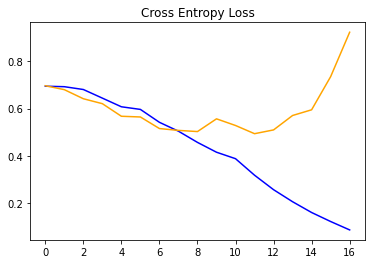

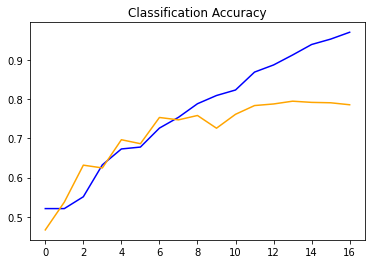

In [18]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [19]:
_, acc = model.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo sin Data Augmentation > %.3f' % (acc * 100.0))

Modelo sin Data Augmentation > 77.452
